<h1>SVRegressor forecast Model for Household Electricity Consumption</h1>

In [14]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h2>Load data</h2>

In [16]:
data=pd.read_csv("/content/drive/MyDrive/household_power_consumption_mod.csv", header=0, index_col=0, parse_dates=True, squeeze=True)
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [17]:
series=data.resample('H').sum()

In [18]:
series = series[:17520]
series.shape

(17520, 8)

In [42]:
train_start_dt =  '2006-12-16 17:24:00'
test_start_dt = '2008-6-15 17:25:00'
test_stop_dt = '2010-1-24 01:24:00'

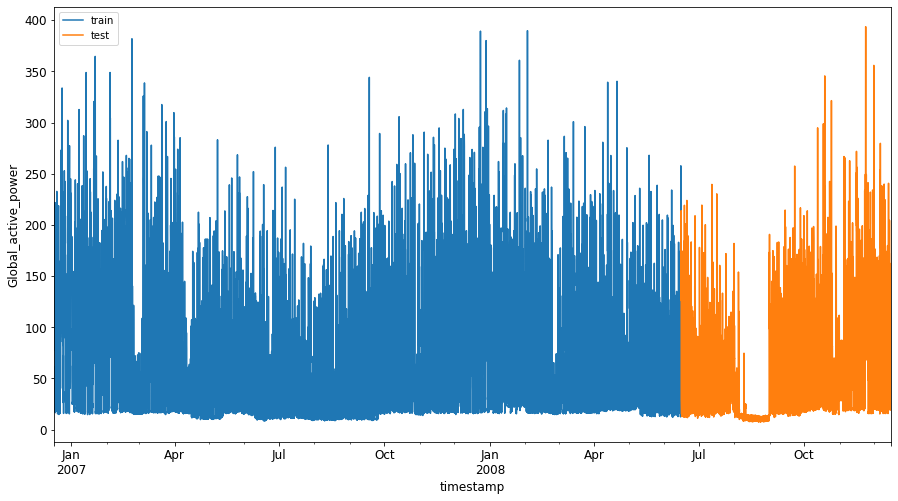

In [43]:
series[(series.index < test_start_dt) & (series.index >= train_start_dt)][['Global_active_power']].rename(columns={'Global_active_power':'train'}) \
    .join(series[test_start_dt:test_stop_dt][['Global_active_power']].rename(columns={'Global_active_power':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Global_active_power', fontsize=12)
plt.show()

In [47]:
train = series.copy()[(series.index >= train_start_dt) & (series.index < test_start_dt)][['Global_active_power']]
test = series.copy()[(series.index >= test_start_dt) & (series.index < test_stop_dt)][['Global_active_power']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)
def forecasts(act,pred):
    scores=[]
    for i in range(act.shape[1]):
        mse=mean_squared_error(act[:,i],pred[:,i])
        rmse=np.sqrt(mse)
        scores.append(rmse)
    s=0
    for row in range(act.shape[0]):
        for col in range(act.shape[1]):
            s+=(act[row,col]-pred[row,col])**2
    score=np.sqrt(s/(act.shape[0]*act.shape[1]))
    return score,scores

Training data shape:  (13128, 1)
Test data shape:  (4391, 1)


In [48]:
scaler = MinMaxScaler()
train['Global_active_power'] = scaler.fit_transform(train)

In [49]:
scaler = MinMaxScaler()
test['Global_active_power'] = scaler.fit_transform(test)

In [50]:
train_data = train.values
test_data = test.values

In [51]:
timesteps=5

In [52]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(13124, 5)

In [53]:
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(4387, 5)

In [54]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(13124, 4) (13124, 1)
(4387, 4) (4387, 1)


<h2>Training model</h2>

In [55]:
model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

In [56]:
model.fit(x_train, y_train[:,0])

SVR(C=10, epsilon=0.05, gamma=0.5)

In [57]:
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma=0.5,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

SVR(C=10, epsilon=0.05, gamma=0.5)

In [58]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(13124, 1) (4387, 1)


In [59]:
# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

print(len(y_train_pred), len(y_test_pred))

13124 4387


In [60]:
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

13124 4387


<h1>Ploting prediction and actual data</h2>

In [65]:
train_timestamps = series[(series.index < test_start_dt) & (series.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = series[test_start_dt:test_stop_dt].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

13124 4387


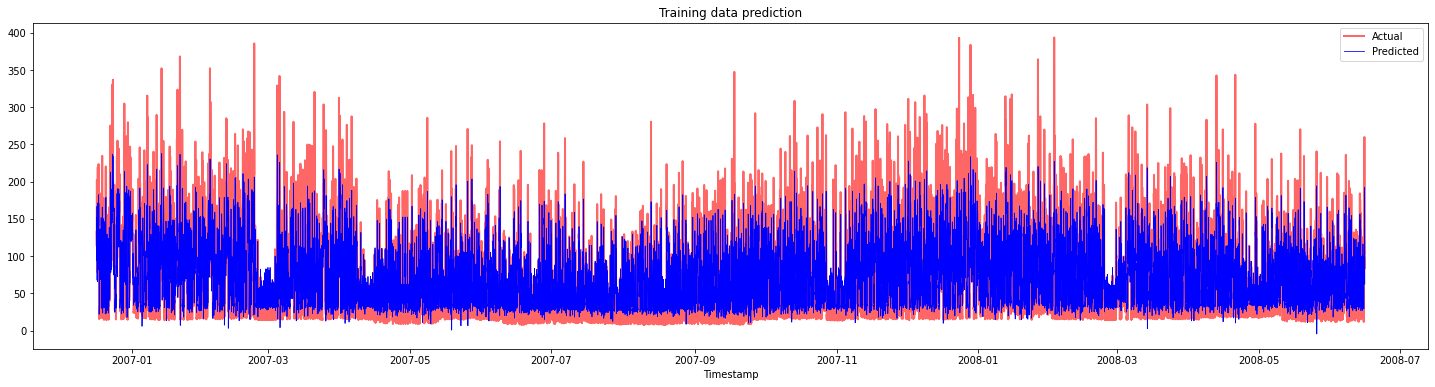

In [71]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

<h2>Evaluat model SVRegressor</h2>

In [72]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

In [73]:
mae(y_train,y_train_pred)

29.531003452335217

In [74]:
from sklearn.metrics import mean_squared_error,r2_score
rmse = np.sqrt(mean_squared_error(y_train,y_train_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 41.099
